<a href="https://colab.research.google.com/github/Newborn1937/zdetect/blob/main/vk_group_members_ipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Get group members from vk

In [1]:
# Install vk api
!pip install vk==2.0.2

import gdown

# Load utility for high-level interaction with vk
url = 'https://raw.githubusercontent.com/Newborn1937/zdetect/main/vk_utils.py'
gdown.download(url)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for vk: filename=vk-2.0.2-py3-none-any.whl size=8278 sha256=392b7fa4b07220a84ecd1a1eaebb701c590492a96cb247d48b150162c316ae9a
  Stored in directory: /root/.cache/pip/wheels/7b/d0/2b/d07628ebced43577b8001d0c9d716f972059535bbaadb1eb9d
Successfully built vk


Downloading...
From: https://raw.githubusercontent.com/Newborn1937/zdetect/main/vk_utils.py
To: /content/vk_utils.py
8.29kB [00:00, 6.11MB/s]                   


'vk_utils.py'

In [2]:
import vk_utils

# Initialize vk api
vk = vk_utils.VkAPI()

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [4]:
from google.colab import files
import os
import pickle

# Put group names or indices here
#group_idx = ['russia', 'zogolovok']
group_idx = ['putin_z', 'vladimir_vladimirovichp', 'putin_govorit', 'putintoday',
             'putin_vs_veteran', 'moskvaputinu', 'putin_2014', 'putin_lider',
             'moy_putin', 'putineveryday']

dirpath_out = '/content/gdrive/MyDrive/vk_group_members'

In [ ]:
# Get group members from vk
members = {}
for group_id in group_idx:
  print(group_id)
  # Get from vk
  members[group_id] = vk.load_group_members(
      group_id, ntoload='all', offset=0, sort_type='id_desc', fields=None)
  # Save the result
  fname_out = f'{group_id}_members.pkl'
  fpath_out = os.path.join(dirpath_out, fname_out)
  with open(fpath_out, 'wb') as fid:
    pickle.dump(members[group_id], fid)

# Download members' data to the local drive
#files.download(fname_out)

In [5]:
# Load group members from Google Drive
members = {}
for group_id in group_idx:
  print(group_id)
  fname_out = f'{group_id}_members.pkl'
  fpath_out = os.path.join(dirpath_out, fname_out)
  with open(fpath_out, 'rb') as fid:
    members_ = pickle.load(fid)
    members[group_id] = members_[group_id]  # Delete this line after reloading from vk

putin_z
vladimir_vladimirovichp
putin_govorit
putintoday
putin_vs_veteran
moskvaputinu
putin_2014
putin_lider
moy_putin
putineveryday


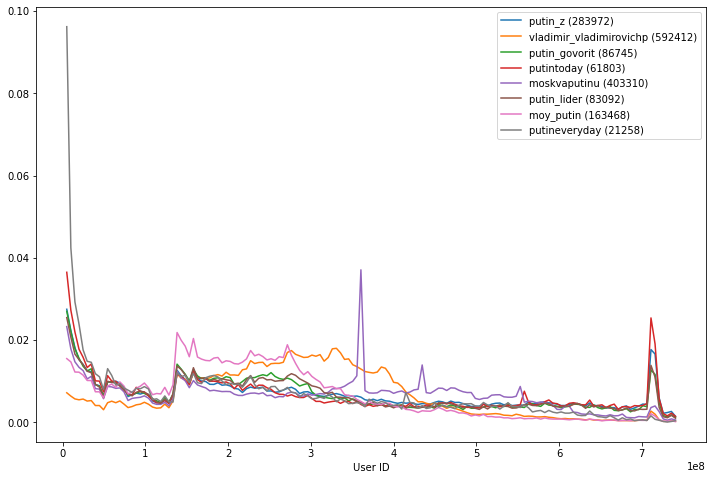

In [76]:
import matplotlib.pyplot as plt
import numpy as np

nbins = 150
hbins = None
h = {}

# Calculate histograms of member indices
for group_id in group_idx:
  member_idx = np.array(members[group_id])
  #member_idx = member_idx[member_idx > 6e8]
  if hbins is None:
    hh, hbins = np.histogram(member_idx, nbins)
  else:
    hh, _ = np.histogram(member_idx, hbins)
  hh = hh / np.sum(hh)
  h[group_id] = hh

groups_excluded = ['putin_vs_veteran', 'putin_2014']

# Visualize the result
plt.figure(figsize=(12,8))
for group_id in group_idx:
  if group_id in groups_excluded:
    continue
  Nmembers = len(members[group_id])
  plt.plot(hbins[1:], h[group_id], label=f'{group_id} ({Nmembers})')
plt.xlabel('User ID')
plt.legend()


In [100]:
import datetime
import re
import urllib
from tqdm import tqdm

def _get_user_reg_date(user_id):
  # Send request to vk server
  req = f'https://vk.com/foaf.php?id={user_id}'
  resp = urllib.request.urlopen(req)
  # Convert response to a string
  resp_str = resp.read().decode(encoding='windows-1251')
  # Find registration date in the response
  templ_str = 'ya:created dc:date="([\d]+-[\d]+-[\d]+)T'
  templ = re.compile(templ_str)
  reg_str = templ.findall(resp_str)
  if len(reg_str) != 1:
    return None
  reg_str = reg_str[0]
  # Convert registration date from string to 'date' object
  reg_date = datetime.date.fromisoformat(reg_str)
  return reg_date

def get_user_reg_date(user_id):
  for n in range(100):
    reg_date = _get_user_reg_date(user_id + n)
    if reg_date is not None:
      return reg_date
  return None


In [101]:
hbin_dates = []
for hbin in tqdm(hbins):
  hbin_dates.append(get_user_reg_date(hbin))

100%|██████████| 151/151 [02:01<00:00,  1.24it/s]


In [109]:
#hbin_dates_ok = [d for d in hbin_dates if d is not None]
#if hbin_dates[0] is None

for n in range(1, len(hbin_dates) - 1):
  if hbin_dates[n] is None:
    dprev = hbin_dates[n - 1]
    dnext = hbin_dates[n + 1]
    if (dprev is not None) and (dnext is not None):
      hbin_dates[n] = dprev + (dnext - dprev) / 2



In [122]:
import plotly.express as px
import pandas as pd

data_lst = []
col_names = []
data_lst.append(hbin_dates[1:])
col_names.append('Date')
for group_id in group_idx:
  if group_id in groups_excluded:
    continue
  data_lst.append(h[group_id])
  col_names.append(group_id)

data_lst = list(map(list, zip(*data_lst)))

#data_lst = [[1,2,3], [4,5,6]]
#col_names = ['x', 'y', 'z']

df = pd.DataFrame(data=data_lst, columns=col_names)

fig = px.line(df, x='Date', y=col_names[1:],
              title='Number of members by registration date') 
fig.show()


In [ ]:
plt.figure(figsize=(12,8))
for group_id in group_idx:
  if group_id in groups_excluded:
    continue
  Nmembers = len(members[group_id])
  plt.plot(hbin_dates[1:], h[group_id], label=f'{group_id} ({Nmembers})')
plt.xlabel('User ID')
plt.legend()